# Reduce WAXS

Exposure time  = 1200 s / (2 images)
Generated "fake" flat field from exposure time at each pixel


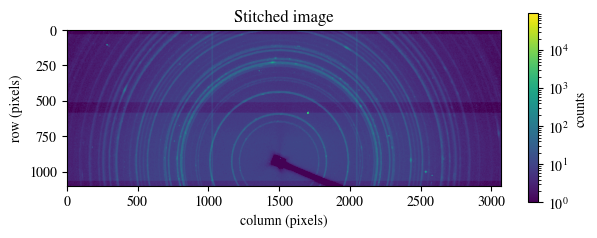

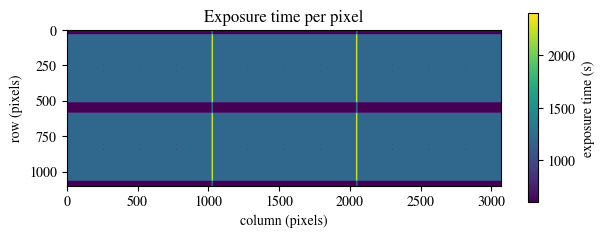

In [1]:
from pathlib import Path
import pyFAI
import fabio
import numpy as np
import yaml
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# need `pip install ipympl` and `jupyter nbextension enable --py widgetsnbextension
#%matplotlib widget 


title = ""  # adds this to the title of plots

IM_SIZE = (6.3, 3)  # inches

raw_stitch = fabio.open("raw-stitched-data.tif").data.astype(np.float64)
flat_field = fabio.open("flat-field.tif").data.astype(np.float64)
with open("params.yaml", "r") as yf:
    params = yaml.safe_load(yf)
    exposure_time = params["exposure"]
print(f"Exposure time  = {exposure_time} s / (2 images)")

print('Generated "fake" flat field from exposure time at each pixel')

fig, ax = plt.subplots(1, 1, figsize=IM_SIZE, facecolor="w")
pos = ax.imshow(raw_stitch, norm=LogNorm(1, np.max(raw_stitch)))
ax.set_title("Stitched image")
ax.set_xlabel("column (pixels)")
ax.set_ylabel("row (pixels)")
fig.colorbar(pos, ax=ax, shrink=0.7, label="counts")
fig.tight_layout()

fig = plt.figure(figsize=IM_SIZE, facecolor="w")
ax1 = plt.subplot()
pos = ax1.imshow(flat_field * exposure_time)
ax1.set_title("Exposure time per pixel")
ax1.set_xlabel("column (pixels)")
ax1.set_ylabel("row (pixels)")
fig.colorbar(pos, ax=ax1, shrink=0.7, label="exposure time (s)")
fig.tight_layout()

# Load PONI file

You must have a `cal.poni` file. This can be made using pyFAI-calib2 GUI

You can create a mask using pyFAI-calib2 GUI

In [2]:
ai = pyFAI.load("cal.poni")
print("Loaded geometry:")
print(ai)
print("")

try:
    mask = fabio.open("mask.edf").data.astype(bool)
    print("Used mask")
except FileNotFoundError:
    mask = np.zeros(raw_stitch.shape)
    print("Did not load mask, you can create one using pyFAI-calib2")

"""Mask pixels that have 0 in the flat field"""
mask = np.logical_or(mask, np.logical_not(flat_field))

Loaded geometry:
Detector Detector	 PixelSize= 7.500e-05, 7.500e-05 m	 TopRight (2)
Wavelength= 1.541850e-10 m
SampleDetDist= 1.399198e-01 m	PONI= 1.295004e-02, 1.118481e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 139.920 mm	Center: x=1491.308, y=172.667 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.542Å

Did not load mask, you can create one using pyFAI-calib2


c:\Users\Teddy\anaconda3\envs\xrd\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


## Adust pixel weights

Also adjust PONI (beam center) by nudging `poni1` and `poni2`

91662.0


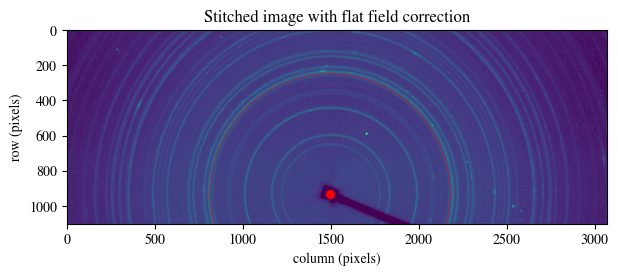

In [3]:
adjusted_stitch = raw_stitch / flat_field
adjusted_stitch[np.where(adjusted_stitch == np.infty)] = 0
adjusted_stitch = np.nan_to_num(adjusted_stitch)
print(adjusted_stitch.max())

fig, ax = plt.subplots(1, 1, figsize=IM_SIZE, facecolor="w")
ax.set_facecolor("black")
pos = ax.imshow(adjusted_stitch, norm=LogNorm(1, np.max(adjusted_stitch)))

poni1 = ai.poni1 - 1 * ai.pixel1
poni2 = ai.poni2 + 5 * ai.pixel2

fig_title = "Stitched image with flat field correction"
if title:
    fig_title = title + "\n" + fig_title
ax.set_title(fig_title)
ax.set_xlabel("column (pixels)")
ax.set_ylabel("row (pixels)")
fig.colorbar(pos, ax=ax1, shrink=0.7)
fig.tight_layout()
fig.savefig(f"{title}-stitch.png".lstrip("-"), dpi=600, bbox_inches="tight")

ax.scatter(poni2 / ai.pixel2 - 0.5, ai.detector.shape[0] - poni1 / ai.pixel1 + 0.5, s=30, color="r")
ax.scatter(poni2 / ai.pixel2 - 0.5, ai.detector.shape[0] - poni1 / ai.pixel1 + 0.5, s=30000, lw=.33, edgecolors="red", facecolors="None")

Save the new PONI.

In [4]:
ai.poni1 = poni1
ai.poni2 = poni2

## Create Cake and reduce data

#### Create Cake

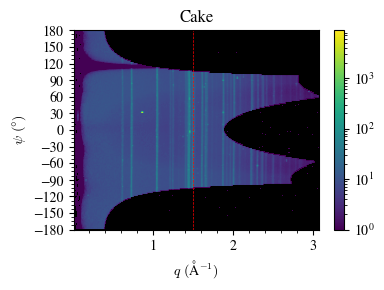

In [5]:
q_bins = 500
azimuthal_bins = 180

ai.rot3 = .5 * np.pi

cake = ai.integrate2d_ng(
    raw_stitch, q_bins, azimuthal_bins,
    radial_range=None,   # In units specified below
    azimuth_range=None,  # Start from 180 degrees to start from the axis to the right
    mask=mask, flat=flat_field,
    error_model="poisson",  unit="q_A^-1",
    polarization_factor=None, correctSolidAngle=False,
)

psi = cake[2]# + 180
# cake_image = np.concatenate((cake[0][int(azimuthal_bins/2):], cake[0][:int(azimuthal_bins/2)]), axis=0)
cake_image = cake[0][::-1]

# ax = jupyter.plot2d(cake)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.set_facecolor("k")
pos = ax.imshow(cake_image, norm=LogNorm(1, np.max(cake[0])),
                extent=(np.min(cake[1]), np.max(cake[1]), np.min(psi), np.max(psi)),
                aspect='auto')
fig_title = "Cake"
if title:
    fig_title = title + "\n" + fig_title
ax.set_title(fig_title)
ax.set_xlabel(r"$q\ (\mathregular{\AA}^{-1})$")
ax.set_ylabel(r"$\psi\ (\degree)$")
ax.set_yticks(np.arange(-180, 181, 30))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.set_xticks(np.arange(0, np.min(cake[1]) + np.max(cake[1]), 0.5))
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
fig.colorbar(pos, ax=ax)
fig.tight_layout()
fig.savefig(f"{title}-cake.png".lstrip("-"), dpi=600, bbox_inches="tight")

# inspect cake with a line
ax.axvline(1.5, color="r", linestyle='--', linewidth=.5)

#### Create reduction

In [ ]:
q_range = None
q_bins = 1000
file_to_save = "reduction.edf"
if (Path.cwd() / file_to_save).is_file():
    (Path.cwd() / file_to_save).unlink()
redu = ai.integrate1d_ng(
    raw_stitch, q_bins, 
    radial_range=q_range,   # In units specified below
    azimuth_range=None,  # Start from 180 degrees to start from the axis to the right
    mask=mask, flat=flat_field, error_model="poisson",
    unit="q_A^-1", filename=f"{title}-reduction.edf".lstrip("-"), normalization_factor=(exposure_time / 60)
)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.scatter(
    redu[0], redu[1],
    s=5,  # marker size
    marker="o",  # marker shape
    edgecolors="black",  # marker edge color
    lw=.75,  # marker edge width
    alpha=1,  # transparency
    facecolor='w'  # marker face color
)

fig_title = "Reduction"
if title:
    fig_title = title + "\n" + fig_title
ax.set_title(fig_title)
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# ax.set_xticks(np.arange(0, np.min(redu[0]) + np.max(redu[0]), 0.5))
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.set_xlabel(r"$q\ (\mathregular{\AA}^{-1})$")
ax.grid(linestyle='dotted')
ax.set_ylabel(r"Intensity (counts / (min $\cdot$ projected pixel area)")
ax.set_yscale("log")
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.savefig(f"{title}-reduction.png".lstrip("-"), dpi=900, bbox_inches="tight")